   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.0 MB/s eta 0:00:00


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'



===== Fairness Metrics =====
Statistical Parity Difference: -0.175
False Positive Rate Difference: 0.139


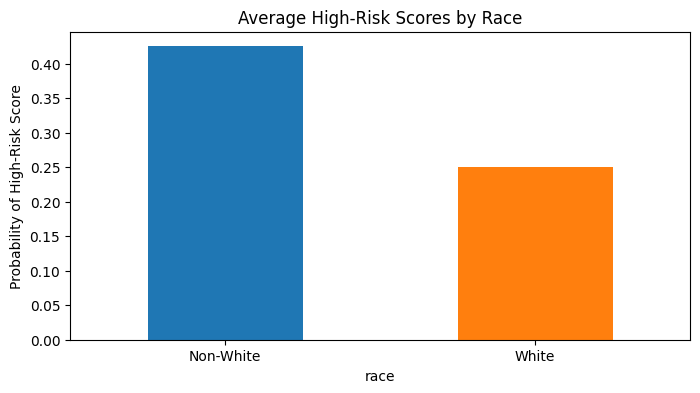

In [1]:
# ===== STEP 1: Install & Import =====
!pip install aif360 pandas matplotlib numpy
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===== STEP 2: Load & Preprocess Data =====
# Download COMPAS dataset
!wget -q https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

# Preprocess data
df = pd.read_csv('compas-scores-two-years.csv')
df = df[['race', 'decile_score', 'two_year_recid']].dropna()

# Create binary labels (1 = high risk, 0 = low risk)
df['risk_high'] = (df['decile_score'] > 5).astype(int)

# Map race to binary (1 = White, 0 = Non-White)
df['race'] = df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)

# Convert to AIF360 format
dataset = BinaryLabelDataset(
    df=df,
    label_names=['risk_high'],
    protected_attribute_names=['race'],
    favorable_label=0,
    unfavorable_label=1
)

# ===== STEP 3: Calculate Fairness Metrics =====
privileged_group = [{'race': 1}]  # White
unprivileged_group = [{'race': 0}]  # Non-White

metric = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=unprivileged_group,
    privileged_groups=privileged_group
)

print("\n===== Fairness Metrics =====")
print("Statistical Parity Difference:", round(metric.statistical_parity_difference(), 3))

# Most reliable way to calculate FPR difference
def calculate_fpr_difference(dataset, privileged_group, unprivileged_group):
    # Convert dataset to dataframe
    df = dataset.convert_to_dataframe()[0]

    # Split into privileged and unprivileged groups
    priv = df[df['race'] == privileged_group[0]['race']]
    unpriv = df[df['race'] == unprivileged_group[0]['race']]

    # Calculate confusion matrix for privileged group
    tn_priv = np.sum((priv['risk_high'] == 0) & (priv['two_year_recid'] == 0))
    fp_priv = np.sum((priv['risk_high'] == 1) & (priv['two_year_recid'] == 0))
    fpr_priv = fp_priv / (fp_priv + tn_priv)

    # Calculate confusion matrix for unprivileged group
    tn_unpriv = np.sum((unpriv['risk_high'] == 0) & (unpriv['two_year_recid'] == 0))
    fp_unpriv = np.sum((unpriv['risk_high'] == 1) & (unpriv['two_year_recid'] == 0))
    fpr_unpriv = fp_unpriv / (fp_unpriv + tn_unpriv)

    return fpr_unpriv - fpr_priv

fpr_diff = calculate_fpr_difference(dataset, privileged_group, unprivileged_group)
print("False Positive Rate Difference:", round(fpr_diff, 3))

# ===== STEP 4: Visualize Bias =====
plt.figure(figsize=(8, 4))
df.groupby('race')['risk_high'].mean().plot(
    kind='bar',
    color=['#1f77b4', '#ff7f0e'],
    title='Average High-Risk Scores by Race'
)
plt.xticks([0, 1], ['Non-White', 'White'], rotation=0)
plt.ylabel('Probability of High-Risk Score')
plt.savefig('risk_disparity.png')
plt.show()